## This is Dev notebook for house prices project from Kaggle

#### 1. Load environment and data

In [1]:
import numpy as np
import pandas as pd
import os, time, warnings, random, shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.special import inv_boxcox
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier, XGBRegressor

pd.set_option('display.max_columns', 100)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()


def fillna_mp_i1(df_train, df_test, df_pred, num_features, cat_features, num_fill='median', cat_fill='mode'):
    """
    This function speeds up filling missing values for 3 main datasets using different imputation methods.
    Later may replace it with some subclass.
    Example: fillna_mp_i1(X_train, X_test, X_pred, num_cols, cat_cols)
    """
    # set df_pred to None if it does not exist
    if (cat_fill=='mode'):
    
        df_train[cat_features] = df_train[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
        df_test[cat_features] = df_test[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
        if (df_pred is not None):
            df_pred[cat_features] = df_pred[cat_features].fillna(value=df_train[cat_features].mode().iloc[0])
            
    if (cat_fill=='missing'):
    
        df_train[cat_features] = df_train[cat_features].fillna(value='missing')
        df_test[cat_features] = df_test[cat_features].fillna(value='missing')
        if (df_pred is not None):
            df_pred[cat_features] = df_pred[cat_features].fillna(value='missing')
        
    if (num_fill=='median'):
        df_train[num_features] = df_train[num_features].fillna(value=df_train[num_features].median())
        df_test[num_features] = df_test[num_features].fillna(value=df_train[num_features].median())
        if (df_pred is not None):
            df_pred[num_features] = df_pred[num_features].fillna(value=df_train[num_features].median())    
    
    all_good = (
    (np.prod(df_train[num_features+cat_features].shape)==df_train[num_features+cat_features].count().sum()) and 
    (np.prod(df_test[num_features+cat_features].shape) == df_test[num_features+cat_features].count().sum()) and 
    (np.prod(df_pred[num_features+cat_features].shape) == df_pred[num_features+cat_features].count().sum()))
    if (all_good):
        print('Missing values imputed successfully')
    else:
        print('There are still some missing values...')
    
    
    
def add_misDummy_mp_i1(df_train, df_test, df_pred, features):
    """
    This function creates new dummy columns for missing features.
    Example: add_misDummy_mp_i1(X_train, X_test, X_pred, ['Age'])
    """
    # set df_pred to None if it does not exist
    for feature_name in features:
        misColName = 'mis'+feature_name
        df_train.loc[df_train[feature_name].isnull(), misColName]=1
        df_train.loc[df_train[feature_name].notnull(), misColName]=0
        df_test.loc[df_test[feature_name].isnull(), misColName]=1
        df_test.loc[df_test[feature_name].notnull(), misColName]=0
        if (df_pred is not None):
            df_pred.loc[df_pred[feature_name].isnull(), misColName]=1
            df_pred.loc[df_pred[feature_name].notnull(), misColName]=0
   

def discretize_mp_i1(df_train, df_test, df_pred, feature, ntiles, delete_feature=False):
    """
    This function divides a continuous feature into quantile groups.
    Example: discretize_mp_i1(X_train, X_test, X_pred, 'Age', 15)
    """
    # set df_pred to None if it does not exist
    _,bin = pd.qcut(df_train[feature], ntiles, retbins = True, labels = False, duplicates = 'drop')
    df_train[feature+'Ntile'] = pd.cut(df_train[feature], 
                                       labels=False, 
                                       duplicates = 'drop', 
                                       bins = bin , 
                                       include_lowest = True)
    df_test[feature+'Ntile'] = pd.cut(df_test[feature], 
                                      labels=False, 
                                      duplicates = 'drop', 
                                      bins = bin , 
                                      include_lowest = True)
    if (df_pred is not None):
        df_pred[feature+'Ntile'] = pd.cut(df_pred[feature], 
                                          labels=False, 
                                          duplicates = 'drop', 
                                          bins = bin , 
                                          include_lowest = True)
    if (delete_feature==True):
        df_train.drop(columns=[feature], inplace=True)
        df_test.drop(columns=[feature], inplace=True)
        df_pred.drop(columns=[feature], inplace=True)
    print('Discretized ',feature, ' into ', len(bin)-1, ' bins')


def log_transformer_mp_i1(df_train, df_test, feature_subset=False, min_skew=3, df_pred=None):
    """
    This function divides a continuous feature into quantile groups.
    Example: log_transformer_mp_i1(X_train, X_test, X_pred, feature_subset=num_cols)
    """
    # set df_pred to None if it does not exist
    if (feature_subset==False):
        features_totransform = df_train.columns
    else:
        features_totransform = feature_subset.copy()
    skewed_vars = list(df_train.skew()[abs(df_train.skew())>min_skew].index)
    for col in list(set(skewed_vars)&set(features_totransform)):
        df_train[col] = np.log1p(df_train[col])
        df_test[col] = np.log1p(df_test[col])
        if df_pred:
            df_pred[col] = np.log1p(df_pred[col])
    print('Skewed columns log-transformed: ', list(set(skewed_vars)&set(features_totransform)))
    
    
def add_dummyfeatures(df_train, df_test, feature_dict, df_pred=None):
    """
    This function adds dummy feature when some feature is equal to value, specified in a dictionary.
    Example: add_dummyfeatures(X_train, X_test, X_pred, {'RoomService':0, 'Spa':0, 'VRDeck':0, 'ShoppingMall':0})
    """
    if df_pred:
        input_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    else:
        input_dimensions = np.array([df_train.shape[1], df_test.shape[1]])    
    for i in range(len(list(feature_dict.items()))):
        feature,value = list(feature_dict.keys())[i], list(feature_dict.values())[i]
        df_train.loc[df_train[feature]==value,(str(feature)+str(value))]=1
        df_train.loc[df_train[feature]!=value,(str(feature)+str(value))]=0
        df_test.loc[df_test[feature]==value,(str(feature)+str(value))]=1
        df_test.loc[df_test[feature]!=value,(str(feature)+str(value))]=0
        if df_pred:
            df_pred.loc[df_pred[feature]==value,(str(feature)+str(value))]=1
            df_pred.loc[df_pred[feature]!=value,(str(feature)+str(value))]=0
    if df_pred:
        output_dimensions = np.array([df_train.shape[1], df_test.shape[1], df_pred.shape[1]])
    else:
        output_dimensions = np.array([df_train.shape[1], df_test.shape[1]])
    print(output_dimensions-input_dimensions, ' variables created') 
    

### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded    

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time0 = time.time()

os.chdir('/home/jupyter/projects_data/house_price')
df = pd.read_csv('train.csv') 
# df.drop(columns = ['Id'], inplace=True)
pred=pd.read_csv('test.csv')
pred0 = pred.copy()

print(df.shape, pred.shape)
df

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

#### 2. Data cleaning and EDA

In [3]:
# 2. pEDA #

cols_tokeep = ['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 
               'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea',  
               'KitchenQual', 'GarageArea', 'GarageCars', 'TotRmsAbvGrd', 'BedroomAbvGr', 'FullBath', 
               'HalfBath', 'MiscVal', 'LotFrontage', 
               'ExterQual', 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
               'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd',
               'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'PavedDrive',
               'SaleType', 'SaleCondition', 'BsmtQual', 'BsmtCond', 
               'BsmtExposure', 'BsmtFinType1', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df = df[cols_tokeep]

# preliminary feature engineering:
df['GrLivArea_log'] = np.log1p(df['GrLivArea'])
pred['GrLivArea_log'] = np.log1p(pred['GrLivArea'])
# w/o logtransform, scatterplot looks better. not sure whether log tranform helps.

df['MisGarage'] = df.GarageType.isnull().astype(int)
df['MisBsmt'] = df.BsmtCond.isnull().astype(int)
df

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,ExterCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MiscVal,LotFrontage,ExterQual,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,Functional,PavedDrive,SaleType,SaleCondition,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,GarageType,GarageFinish,GarageQual,GarageCond,GrLivArea_log,MisGarage,MisBsmt
0,208500,8450,7,5,2003,TA,706,0,856,Ex,856,854,1710,Gd,548,2,8,3,2,1,0,65.0,Gd,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,Gd,TA,No,GLQ,Attchd,RFn,TA,TA,7.444833,0,0
1,181500,9600,6,8,1976,TA,978,0,1262,Ex,1262,0,1262,TA,460,2,6,3,2,0,0,80.0,TA,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,MetalSd,CBlock,GasA,Y,SBrkr,Typ,Y,WD,Normal,Gd,TA,Gd,ALQ,Attchd,RFn,TA,TA,7.141245,0,0
2,223500,11250,7,5,2001,TA,486,0,920,Ex,920,866,1786,Gd,608,2,6,3,2,1,0,68.0,Gd,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,Gd,TA,Mn,GLQ,Attchd,RFn,TA,TA,7.488294,0,0
3,140000,9550,7,5,1915,TA,216,0,756,Gd,961,756,1717,Gd,642,3,7,3,1,0,0,60.0,TA,70,RL,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,BrkTil,GasA,Y,SBrkr,Typ,Y,WD,Abnorml,TA,Gd,No,ALQ,Detchd,Unf,TA,TA,7.448916,0,0
4,250000,14260,8,5,2000,TA,655,0,1145,Ex,1145,1053,2198,Gd,836,3,9,4,2,1,0,84.0,Gd,60,RL,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,Gd,TA,Av,GLQ,Attchd,RFn,TA,TA,7.695758,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,7917,6,5,1999,TA,0,0,953,Ex,953,694,1647,TA,460,2,7,3,2,1,0,62.0,TA,60,RL,Reg,Lvl,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,Gd,TA,No,Unf,Attchd,RFn,TA,TA,7.407318,0,0
1456,210000,13175,6,6,1978,TA,790,163,1542,TA,2073,0,2073,TA,500,2,7,3,2,0,0,85.0,TA,20,RL,Reg,Lvl,Inside,NWAmes,Norm,1Fam,1Story,Gable,Plywood,Plywood,CBlock,GasA,Y,SBrkr,Min1,Y,WD,Normal,Gd,TA,No,ALQ,Attchd,Unf,TA,TA,7.637234,0,0
1457,266500,9042,7,9,1941,Gd,275,0,1152,Ex,1188,1152,2340,Gd,252,1,9,4,2,0,2500,66.0,Ex,70,RL,Reg,Lvl,Inside,Crawfor,Norm,1Fam,2Story,Gable,CemntBd,CmentBd,Stone,GasA,Y,SBrkr,Typ,Y,WD,Normal,TA,Gd,No,GLQ,Attchd,RFn,TA,TA,7.758333,0,0
1458,142125,9717,5,6,1950,TA,49,1029,1078,Gd,1078,0,1078,Gd,240,1,5,2,1,0,0,68.0,TA,20,RL,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,Hip,MetalSd,MetalSd,CBlock,GasA,Y,FuseA,Typ,Y,WD,Normal,TA,TA,Mn,GLQ,Attchd,Unf,TA,TA,6.983790,0,0


In [4]:
ord_cols = ['ExterCond', 'HeatingQC', 'KitchenQual', 'ExterQual', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']
num_cols = ['LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
            'GrLivArea', 'GarageArea', 'MiscVal', 'LotFrontage', 
           'TotRmsAbvGrd', 'GarageCars', 'BedroomAbvGr', 'OverallCond', 'OverallQual', 'GrLivArea_log']
cat_cols = list(set(df.columns)-set(num_cols)-set(ord_cols)-set(['SalePrice']))
print("Numerical features ", num_cols, "\n",
      'Ordinal features', ord_cols, '\n',
      "Categorical features ", cat_cols)

df[ord_cols] = df[ord_cols].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])
pred[ord_cols] = pred[ord_cols].replace(['Po', 'Fa', 'TA', 'Gd', 'Ex'], [1,2,3,4,5])

Numerical features  ['LotArea', 'YearBuilt', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MiscVal', 'LotFrontage', 'TotRmsAbvGrd', 'GarageCars', 'BedroomAbvGr', 'OverallCond', 'OverallQual', 'GrLivArea_log'] 
 Ordinal features ['ExterCond', 'HeatingQC', 'KitchenQual', 'ExterQual', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond'] 
 Categorical features  ['HouseStyle', 'Heating', 'SaleCondition', 'MisBsmt', 'LandContour', 'BsmtExposure', 'CentralAir', 'GarageFinish', 'Foundation', 'MSZoning', 'MSSubClass', 'RoofStyle', 'Functional', 'Neighborhood', 'BldgType', 'PavedDrive', 'Electrical', 'Exterior1st', 'LotConfig', 'BsmtFinType1', 'HalfBath', 'LotShape', 'GarageType', 'Condition1', 'SaleType', 'FullBath', 'MisGarage', 'Exterior2nd']


In [5]:
df[cat_cols].nunique()

HouseStyle        8
Heating           6
SaleCondition     6
MisBsmt           2
LandContour       4
BsmtExposure      4
CentralAir        2
GarageFinish      3
Foundation        6
MSZoning          5
MSSubClass       15
RoofStyle         6
Functional        7
Neighborhood     25
BldgType          5
PavedDrive        3
Electrical        5
Exterior1st      15
LotConfig         5
BsmtFinType1      6
HalfBath          3
LotShape          4
GarageType        6
Condition1        9
SaleType          9
FullBath          4
MisGarage         2
Exterior2nd      16
dtype: int64

According to feature importances, only Neighboorhood and possibly Exterior1 categorical features are really useful.
And they have too many unique values to use OHC. All other categorical features are not important enough to bother with ohe.
So use target encoding for all of them.

In [6]:
test_size = 0.2
df.reset_index(inplace=True, drop=True)
#random.seed(2)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train.drop(columns=['id'],inplace=True, errors='ignore')
test.drop(columns=['id'],inplace=True, errors='ignore')
display(train.shape, test.shape, train.head(3), test.head(3))

(1168, 54)

(292, 54)

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,ExterCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MiscVal,LotFrontage,ExterQual,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,Functional,PavedDrive,SaleType,SaleCondition,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,GarageType,GarageFinish,GarageQual,GarageCond,GrLivArea_log,MisGarage,MisBsmt
0,208500,8450,7,5,2003,3,706,0,856,5,856,854,1710,4,548,2,8,3,2,1,0,65.0,4,60,RL,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,4.0,3.0,No,GLQ,Attchd,RFn,3.0,3.0,7.444833,0,0
1,181500,9600,6,8,1976,3,978,0,1262,5,1262,0,1262,3,460,2,6,3,2,0,0,80.0,3,20,RL,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,MetalSd,CBlock,GasA,Y,SBrkr,Typ,Y,WD,Normal,4.0,3.0,Gd,ALQ,Attchd,RFn,3.0,3.0,7.141245,0,0
2,223500,11250,7,5,2001,3,486,0,920,5,920,866,1786,4,608,2,6,3,2,1,0,68.0,4,60,RL,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,PConc,GasA,Y,SBrkr,Typ,Y,WD,Normal,4.0,3.0,Mn,GLQ,Attchd,RFn,3.0,3.0,7.488294,0,0


,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,ExterCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,FullBath,HalfBath,MiscVal,LotFrontage,ExterQual,MSSubClass,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,Foundation,Heating,CentralAir,Electrical,Functional,PavedDrive,SaleType,SaleCondition,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,GarageType,GarageFinish,GarageQual,GarageCond,GrLivArea_log,MisGarage,MisBsmt
0,115000,10434,4,5,1955,3,0,0,1005,3,1005,0,1005,2,672,2,5,2,1,0,0,60.0,3,20,RL,Reg,Lvl,Inside,NAmes,Norm,1Fam,1Story,Gable,Plywood,Plywood,CBlock,GasA,Y,SBrkr,Typ,Y,WD,Normal,3.0,3.0,No,Unf,Detchd,Unf,2.0,2.0,6.913737,0,0
1,184000,9120,7,6,1925,4,329,0,1026,5,1133,687,1820,3,240,1,8,4,2,0,0,60.0,3,50,RL,Reg,Lvl,Inside,BrkSide,Norm,1Fam,1.5Fin,Gable,Wd Sdng,Wd Sdng,PConc,GasA,Y,SBrkr,Typ,N,WD,Normal,3.0,3.0,No,Rec,Detchd,Unf,3.0,3.0,7.507141,0,0
2,120000,6000,3,7,1948,4,331,0,649,5,679,504,1183,3,308,1,6,2,1,1,0,50.0,3,50,RM,Reg,Lvl,Inside,OldTown,Norm,1Fam,1.5Fin,Gable,MetalSd,MetalSd,CBlock,GasA,Y,SBrkr,Typ,Y,WD,Normal,3.0,3.0,No,ALQ,Detchd,Unf,3.0,3.0,7.076654,0,0


In [7]:
# fill missing values
display(train.info())

mis_col_mode = ['LotFrontage', 'Electrical']
mis_cat_cols = ['BsmtExposure', 'BsmtFinType1', 'GarageType', 'GarageFinish']
mis_num_cols = ['BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond']

for col in mis_col_mode:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(train[col].mode()[0])

for col in mis_cat_cols:
    train[col] = train[col].fillna(value='missing')
    test[col] = test[col].fillna(value='missing')
    
for col in mis_num_cols:
    train[col] = train[col].fillna(value=-1)
    test[col] = test[col].fillna(value=-1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 54 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SalePrice      1168 non-null   int64  
 1   LotArea        1168 non-null   int64  
 2   OverallQual    1168 non-null   int64  
 3   OverallCond    1168 non-null   int64  
 4   YearBuilt      1168 non-null   int64  
 5   ExterCond      1168 non-null   int64  
 6   BsmtFinSF1     1168 non-null   int64  
 7   BsmtFinSF2     1168 non-null   int64  
 8   TotalBsmtSF    1168 non-null   int64  
 9   HeatingQC      1168 non-null   int64  
 10  1stFlrSF       1168 non-null   int64  
 11  2ndFlrSF       1168 non-null   int64  
 12  GrLivArea      1168 non-null   int64  
 13  KitchenQual    1168 non-null   int64  
 14  GarageArea     1168 non-null   int64  
 15  GarageCars     1168 non-null   int64  
 16  TotRmsAbvGrd   1168 non-null   int64  
 17  BedroomAbvGr   1168 non-null   int64  
 18  FullBath

None

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

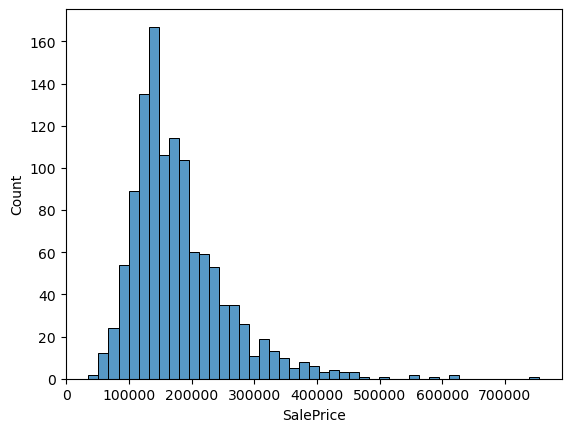

In [8]:
sns.histplot(x='SalePrice', data=train)

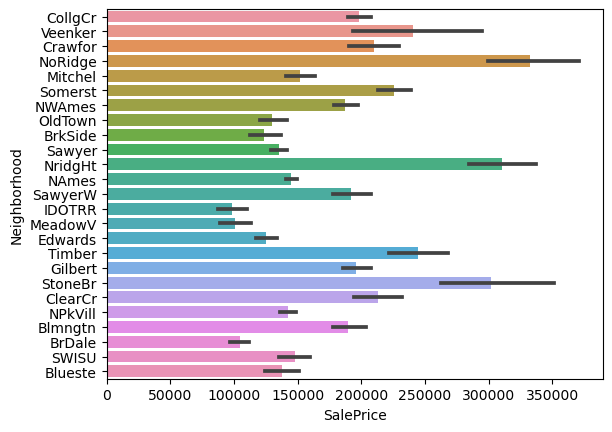

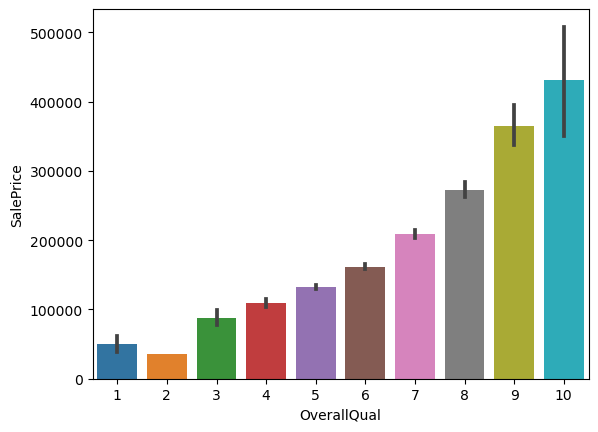

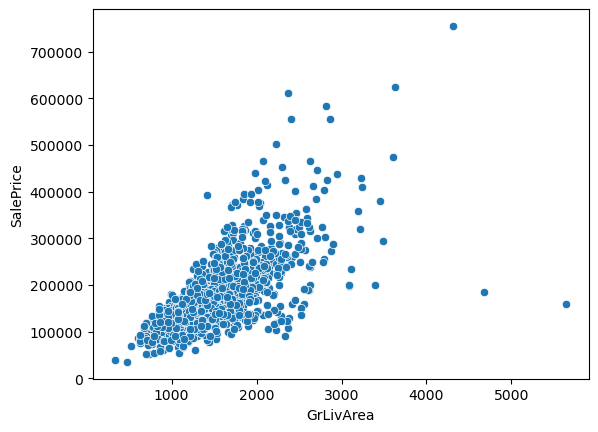

In [9]:
sns.barplot(x='SalePrice', y='Neighborhood', data = train)
plt.show()
sns.barplot(y='SalePrice', x='OverallQual', data = train)
plt.show()
sns.scatterplot(y='SalePrice', x='GrLivArea', data = train)
plt.show()


#### 3. Feature engineering

In [10]:
train['SalePrice'] = np.log(train['SalePrice'])
test['SalePrice'] = np.log(test['SalePrice'])

# do target encoding #

encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.SalePrice, cols=cat_cols)
test_encoded = encoder.transform(test)

train.drop(columns=cat_cols, inplace=True)
test.drop(columns=cat_cols,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

(1168, 54)

,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,ExterCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,MiscVal,LotFrontage,ExterQual,BsmtQual,BsmtCond,GarageQual,GarageCond,GrLivArea_log,HouseStyle_encoded,Heating_encoded,SaleCondition_encoded,MisBsmt_encoded,LandContour_encoded,BsmtExposure_encoded,CentralAir_encoded,GarageFinish_encoded,Foundation_encoded,MSZoning_encoded,MSSubClass_encoded,RoofStyle_encoded,Functional_encoded,Neighborhood_encoded,BldgType_encoded,PavedDrive_encoded,Electrical_encoded,Exterior1st_encoded,LotConfig_encoded,BsmtFinType1_encoded,HalfBath_encoded,LotShape_encoded,GarageType_encoded,Condition1_encoded,SaleType_encoded,FullBath_encoded,MisGarage_encoded,Exterior2nd_encoded
0,12.247694,8450,7,5,2003,3,706,0,856,5,856,854,1710,4,548,2,8,3,0,65.0,4,4.0,3.0,3.0,3.0,7.444833,12.157361,12.021214,11.996982,12.028683,12.014599,11.951275,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.04839,12.192713,11.986690,12.288208,12.180294,11.929336,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095
1,12.109011,9600,6,8,1976,3,978,0,1262,5,1262,0,1262,3,460,2,6,3,0,80.0,3,4.0,3.0,3.0,3.0,7.141245,11.988946,12.021214,11.996982,12.028683,12.014599,12.330332,12.046447,12.162324,11.863254,12.065123,12.046638,11.977362,12.031198,12.129745,12.040038,12.046489,12.04839,11.868455,12.038233,11.962002,11.918054,11.929336,12.155484,11.865464,11.980678,12.195795,12.043256,11.869748
2,12.317167,11250,7,5,2001,3,486,0,920,5,920,866,1786,4,608,2,6,3,0,68.0,4,4.0,3.0,3.0,3.0,7.488294,12.157361,12.021214,11.996982,12.028683,12.014599,12.069062,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.04839,12.192713,11.986690,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095
3,11.849398,9550,7,5,1915,3,216,0,756,4,961,756,1717,4,642,3,7,3,0,60.0,3,3.0,4.0,3.0,3.0,7.448916,12.157361,12.021214,11.799645,12.028683,12.014599,11.951275,12.046447,11.820237,11.765133,12.065123,12.017125,11.977362,12.031198,12.162933,12.040038,12.046489,12.04839,11.856280,12.021535,11.962002,11.918054,12.151729,11.768247,12.027733,11.980678,11.771225,12.043256,11.849550
4,12.429216,14260,8,5,2000,3,655,0,1145,5,1145,1053,2198,4,836,3,9,4,0,84.0,4,4.0,3.0,3.0,3.0,7.695758,12.157361,12.021214,11.996982,12.028683,12.014599,12.123090,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.513509,12.040038,12.046489,12.04839,12.192713,12.038233,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095


SalePrice                1168
LotArea                  1168
OverallQual              1168
OverallCond              1168
YearBuilt                1168
ExterCond                1168
BsmtFinSF1               1168
BsmtFinSF2               1168
TotalBsmtSF              1168
HeatingQC                1168
1stFlrSF                 1168
2ndFlrSF                 1168
GrLivArea                1168
KitchenQual              1168
GarageArea               1168
GarageCars               1168
TotRmsAbvGrd             1168
BedroomAbvGr             1168
MiscVal                  1168
LotFrontage              1168
ExterQual                1168
BsmtQual                 1168
BsmtCond                 1168
GarageQual               1168
GarageCond               1168
GrLivArea_log            1168
HouseStyle_encoded       1168
Heating_encoded          1168
SaleCondition_encoded    1168
MisBsmt_encoded          1168
LandContour_encoded      1168
BsmtExposure_encoded     1168
CentralAir_encoded       1168
GarageFini

In [11]:
add_dummyfeatures(train, test, {'OverallQual':1})
add_dummyfeatures(train, test, {'OverallQual':8})
add_dummyfeatures(train, test, {'OverallQual':9})
add_dummyfeatures(train, test, {'OverallQual':10})

log_transformer_mp_i1(train, test, feature_subset=num_cols)

train

[1 1]  variables created
[1 1]  variables created
[1 1]  variables created
[1 1]  variables created
Skewed columns log-transformed:  ['LotArea', 'BsmtFinSF2', 'MiscVal']


,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,ExterCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,KitchenQual,GarageArea,GarageCars,TotRmsAbvGrd,BedroomAbvGr,MiscVal,LotFrontage,ExterQual,BsmtQual,BsmtCond,GarageQual,GarageCond,GrLivArea_log,HouseStyle_encoded,Heating_encoded,SaleCondition_encoded,MisBsmt_encoded,LandContour_encoded,BsmtExposure_encoded,CentralAir_encoded,GarageFinish_encoded,Foundation_encoded,MSZoning_encoded,MSSubClass_encoded,RoofStyle_encoded,Functional_encoded,Neighborhood_encoded,BldgType_encoded,PavedDrive_encoded,Electrical_encoded,Exterior1st_encoded,LotConfig_encoded,BsmtFinType1_encoded,HalfBath_encoded,LotShape_encoded,GarageType_encoded,Condition1_encoded,SaleType_encoded,FullBath_encoded,MisGarage_encoded,Exterior2nd_encoded,OverallQual1,OverallQual8,OverallQual9,OverallQual10
0,12.247694,9.042040,7,5,2003,3,706,0.000000,856,5,856,854,1710,4,548,2,8,3,0.000000,65.0,4,4.0,3.0,3.0,3.0,7.444833,12.157361,12.021214,11.996982,12.028683,12.014599,11.951275,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.048390,12.192713,11.986690,12.288208,12.180294,11.929336,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,0.0,0.0,0.0
1,12.109011,9.169623,6,8,1976,3,978,0.000000,1262,5,1262,0,1262,3,460,2,6,3,0.000000,80.0,3,4.0,3.0,3.0,3.0,7.141245,11.988946,12.021214,11.996982,12.028683,12.014599,12.330332,12.046447,12.162324,11.863254,12.065123,12.046638,11.977362,12.031198,12.129745,12.040038,12.046489,12.048390,11.868455,12.038233,11.962002,11.918054,11.929336,12.155484,11.865464,11.980678,12.195795,12.043256,11.869748,0.0,0.0,0.0,0.0
2,12.317167,9.328212,7,5,2001,3,486,0.000000,920,5,920,866,1786,4,608,2,6,3,0.000000,68.0,4,4.0,3.0,3.0,3.0,7.488294,12.157361,12.021214,11.996982,12.028683,12.014599,12.069062,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.048390,12.192713,11.986690,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,0.0,0.0,0.0
3,11.849398,9.164401,7,5,1915,3,216,0.000000,756,4,961,756,1717,4,642,3,7,3,0.000000,60.0,3,3.0,4.0,3.0,3.0,7.448916,12.157361,12.021214,11.799645,12.028683,12.014599,11.951275,12.046447,11.820237,11.765133,12.065123,12.017125,11.977362,12.031198,12.162933,12.040038,12.046489,12.048390,11.856280,12.021535,11.962002,11.918054,12.151729,11.768247,12.027733,11.980678,11.771225,12.043256,11.849550,0.0,0.0,0.0,0.0
4,12.429216,9.565284,8,5,2000,3,655,0.000000,1145,5,1145,1053,2198,4,836,3,9,4,0.000000,84.0,4,4.0,3.0,3.0,3.0,7.695758,12.157361,12.021214,11.996982,12.028683,12.014599,12.123090,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.513509,12.040038,12.046489,12.048390,12.192713,12.038233,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,12.128111,8.922792,7,5,2004,3,410,0.000000,1221,5,1221,0,1221,4,400,2,6,2,0.000000,62.0,4,4.0,3.0,3.0,3.0,7.108244,11.986534,12.026977,12.003441,12.040265,12.022557,11.962563,12.057066,12.182690,12.254572,12.223515,12.036240,11.995743,12.042015,12.264533,12.054400,12.056342,12.059559,12.213693,12.005163,12.286749,11.921928,11.940230,12.149095,12.041396,11.988540,12.205316,12.051597,12.217795,0.0,0.0,0.0,0.0
1164,12.072541,8.976894,6,5,1999,3,0,0.000000,953,5,953,694,1647,3,460,2,7,3,0.000000,62.0,3,4.0,3.0,3.0,3.0,7.407318,12.184942,12.026977,12.003441,12.040265,12.022557,11.962563,12.057066,12.182690,12.254572,12.079008,12.329685,11.995743,12.042015,12.131708,12.054400,12.056342,12.059559,12.213693,12.005163,11.973409,12.195151,11.940230,12.149095,12.041396,11.988540,12.205316,12.051597,12.217795,0.0,0.0,0.0,0.0
1165,12.2

In [12]:
X_train = train.copy()
y_train = X_train.pop('SalePrice')
X_test = test.copy()
y_test = X_test.pop('SalePrice')
print(X_train.shape, X_test.shape, y_train.shape)


(1168, 57) (292, 57) (1168,)


In [13]:
feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols+ord_cols),
    ], remainder = "passthrough")

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), 
                       columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), 
                      columns=feature_transformer.get_feature_names_out())

# there are many dummies... may wish to use pca here later.

print(X_train.shape, X_test.shape, y_train.shape)
display(X_train)

(1168, 57) (292, 57) (1168,)


,num__LotArea,num__YearBuilt,num__BsmtFinSF1,num__BsmtFinSF2,num__TotalBsmtSF,num__1stFlrSF,num__2ndFlrSF,num__GrLivArea,num__GarageArea,num__MiscVal,num__LotFrontage,num__TotRmsAbvGrd,num__GarageCars,num__BedroomAbvGr,num__OverallCond,num__OverallQual,num__GrLivArea_log,num__ExterCond,num__HeatingQC,num__KitchenQual,num__ExterQual,num__BsmtQual,num__BsmtCond,num__GarageQual,num__GarageCond,remainder__HouseStyle_encoded,remainder__Heating_encoded,remainder__SaleCondition_encoded,remainder__MisBsmt_encoded,remainder__LandContour_encoded,remainder__BsmtExposure_encoded,remainder__CentralAir_encoded,remainder__GarageFinish_encoded,remainder__Foundation_encoded,remainder__MSZoning_encoded,remainder__MSSubClass_encoded,remainder__RoofStyle_encoded,remainder__Functional_encoded,remainder__Neighborhood_encoded,remainder__BldgType_encoded,remainder__PavedDrive_encoded,remainder__Electrical_encoded,remainder__Exterior1st_encoded,remainder__LotConfig_encoded,remainder__BsmtFinType1_encoded,remainder__HalfBath_encoded,remainder__LotShape_encoded,remainder__GarageType_encoded,remainder__Condition1_encoded,remainder__SaleType_encoded,remainder__FullBath_encoded,remainder__MisGarage_encoded,remainder__Exterior2nd_encoded,remainder__OverallQual1,remainder__OverallQual8,remainder__OverallQual9,remainder__OverallQual10
0,-0.119919,1.052636,0.576637,-0.353116,-0.446911,-0.790249,1.142987,0.362493,0.353318,-0.193912,-0.146003,0.883577,0.315551,0.142866,-0.513932,0.662767,0.523497,-0.246047,0.896012,0.738089,1.070019,0.543150,0.138336,0.263048,0.26464,12.157361,12.021214,11.996982,12.028683,12.014599,11.951275,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.048390,12.192713,11.986690,12.288208,12.180294,11.929336,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,0.0,0.0,0.0
1,0.122265,0.160632,1.170263,-0.353116,0.468710,0.264324,-0.801447,-0.484676,-0.059404,-0.193912,0.502241,-0.331276,0.315551,0.142866,2.153944,-0.067527,-0.385756,-0.246047,0.896012,-0.787731,-0.695210,0.543150,0.138336,0.263048,0.26464,11.988946,12.021214,11.996982,12.028683,12.014599,12.330332,12.046447,12.162324,11.863254,12.065123,12.046638,11.977362,12.031198,12.129745,12.040038,12.046489,12.048390,11.868455,12.038233,11.962002,11.918054,11.929336,12.155484,11.865464,11.980678,12.195795,12.043256,11.869748,0.0,0.0,0.0,0.0
2,0.423308,0.986562,0.096499,-0.353116,-0.302577,-0.624011,1.170310,0.506209,0.634719,-0.193912,-0.016354,-0.331276,0.315551,0.142866,-0.513932,0.662767,0.653662,-0.246047,0.896012,0.738089,1.070019,0.543150,0.138336,0.263048,0.26464,12.157361,12.021214,11.996982,12.028683,12.014599,12.069062,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.145709,12.040038,12.046489,12.048390,12.192713,11.986690,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,0.0,0.0,0.0
3,0.112353,-1.854636,-0.492763,-0.353116,-0.672434,-0.517515,0.919856,0.375730,0.794180,-0.193912,-0.362084,0.276150,1.655785,0.142866,-0.513932,0.662767,0.535726,-0.246047,-0.146360,0.738089,-0.695210,-0.452767,1.543344,0.263048,0.26464,12.157361,12.021214,11.799645,12.028683,12.014599,11.951275,12.046447,11.820237,11.765133,12.065123,12.017125,11.977362,12.031198,12.162933,12.040038,12.046489,12.048390,11.856280,12.021535,11.962002,11.918054,12.151729,11.768247,12.027733,11.980678,11.771225,12.043256,11.849550,0.0,0.0,0.0,0.0
4,0.873330,0.953524,0.465332,-0.353116,0.204849,-0.039580,1.596082,1.285302,1.704045,-0.193912,0.675106,1.491003,1.655785,1.343349,-0.513932,1.393062,1.275022,-0.246047,0.896012,0.738089,1.070019,0.543150,0.138336,0.263048,0.26464,12.157361,12.021214,11.996982,12.028683,12.014599,12.123090,12.046447,12.162324,12.250042,12.065123,12.307265,11.977362,12.031198,12.513509,12.040038,12.046489,12.048390,12.192713,12.038233,12.288208,12.180294,12.151729,12.155484,12.027733,11.980678,12.195795,12.043256,12.199095,0.0,1.0,0.0,0.0
...,...,...,...,...,..

#### 4. Modeling

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('OLS ', mean_squared_error(y_train, lr.predict(X_train))**0.5)

OLS  0.12212735221998297


In [15]:
xgbb = XGBRegressor(n_estimators=200,
                   max_depth=5,
                   eta=0.06,
                   subsample=0.8,
                   colsample_bytree=0.6)
xgbb.fit(X_train, y_train)
print('xgb ', mean_squared_error(y_train, xgbb.predict(X_train))**0.5)

xgb  0.05193799946621277


In [16]:
xgbgs = XGBRegressor()
grid_param = {'n_estimators':[200], 
              'max_depth':[2, 3, 4], 
              'eta':[0.05, 0.07, 0.09],
              'subsample':[0.7], 
              'colsample_bytree':[0.5]}
xgbgs = GridSearchCV(xgbgs, grid_param, cv=2, scoring='neg_root_mean_squared_error')
xgbgs.fit(X_train, y_train)

print('xgbgs ',       
      xgbgs.best_params_, 
      xgbgs.best_score_, 
      mean_squared_error(y_train, xgbgs.predict(X_train))**0.5)

xgbgs  {'colsample_bytree': 0.5, 'eta': 0.07, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7} -0.1316590605051451 0.061257887770893193


In [17]:
y_train = np.exp(y_train)
y_test = np.exp(y_test)

# performance evaluation: train set
print('Train: ')
print('OLS', np.sqrt(mean_squared_error(y_train, np.exp(lr.predict(X_train)))))
print('XGB', np.sqrt(mean_squared_error(y_train, np.exp(xgbb.predict(X_train)))))
print('XGBgs', np.sqrt(mean_squared_error(y_train, np.exp(xgbgs.predict(X_train)))))

# performance evaluation: test set
print('Test: ')
print('OLS', np.sqrt(mean_squared_error(y_test, np.exp(lr.predict(X_test)))))
print('XGB', np.sqrt(mean_squared_error(y_test, np.exp(xgbb.predict(X_test)))))
print('XGBgs', np.sqrt(mean_squared_error(y_test, np.exp(xgbgs.predict(X_test)))))

Train: 
OLS 27305.244368959433
XGB 9422.199907819397
XGBgs 11637.762940118824
Test: 
OLS 30315.56000381662
XGB 27967.492963084325
XGBgs 28800.485531992847


In [18]:
# SVR sucks, so I omit it.
# as usual, XGB GS fails to clearly beat XGB baseline.

#### 5. Feature importance

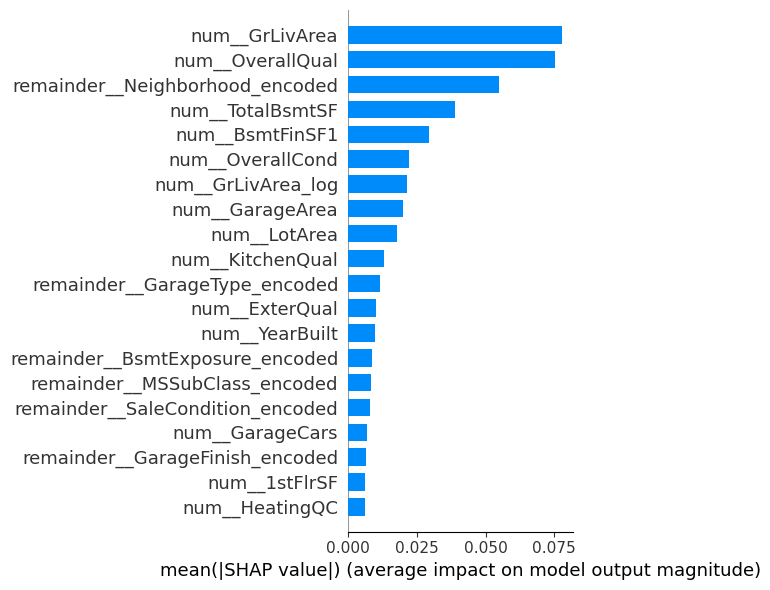

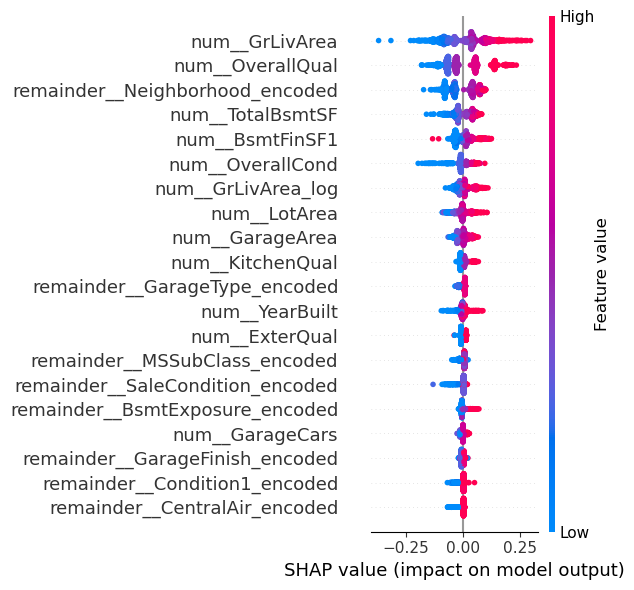

In [19]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(xgbb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(6,6), max_display=20)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(6,6), max_display=20)

In [20]:
print('Total time for this Dev script: ', time.time() - time0)

Total time for this Dev script:  17.235257625579834
